In [1]:
# Installing YOLO
!pip install -U ultralytics

In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

In [5]:
# Exploring Dataset

# Get the current working directory
root_dir = os.getcwd()

# Define the path to the dataset directory named 'PCB_DATASET' within the current working directory
dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

# Walk through the dataset directory to explore its subdirectories and files
# `os.walk()` generates the file names in a directory tree by walking top-down
for root, dirs, files in os.walk(dataset_dir):
    
    # Iterate over each subdirectory in the current directory
    for name in dirs:
        
        # Print the full path of each subdirectory
        print(os.path.join(root, name))

c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\Annotations
c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\images
c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\images_resized
c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output
c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\PCB_USED
c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\rotation
c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\Annotations\Missing_hole
c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V P

In [6]:
def count_files_in_folder(folder_path):
    """
    Count the number of files in a specified folder.

    Parameters:
    - folder_path (str): The path to the folder whose files need to be counted.

    Returns:
    - int: The number of files in the specified folder.
    """
    
    # Get a list of all items (files and directories) in the specified folder
    files = os.listdir(folder_path)

    # Count the number of items in the list
    # This includes all files and subdirectories present in the folder
    num_files = len(files)

    # Return the count of files (or items) in the folder
    return num_files


In [7]:
# List of subfolder names representing different PCB defect classes
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

# Define the path to the images directory within the dataset
images_dir = os.path.join(dataset_dir, 'images')

# Define the path to the annotations directory within the dataset
annot_dir = os.path.join(dataset_dir, 'Annotations')

# Iterate through each subfolder in the list
for subfolder in subfolders:
    
    # Construct the full path to the images subdirectory for the current defect type
    images_path = os.path.join(images_dir, subfolder)
    
    # Construct the full path to the annotations subdirectory for the current defect type
    annot_path = os.path.join(annot_dir, subfolder)

    # Print the subfolder name, and the count of images and annotations it contains
    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


In [8]:
# Creating annotation dataset
def parse_xml(xml_file):
    """
    Parse an XML file to extract annotation data for PCB defect detection.

    Parameters:
    - xml_file (str): The path to the XML file.

    Returns:
    - list: A list of dictionaries containing annotation details.
            Each dictionary includes the filename, image dimensions,
            object class, and bounding box coordinates (xmin, ymin, xmax, ymax).
    """
    
    # Parse the XML file and get the root element
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    # Initialize an empty list to store annotation data
    data = []

    # Extract the filename, image width, and height
    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    # Iterate over all object elements in the XML file
    for obj in root.findall('object'):
        
        # Extract the class name and bounding box coordinates
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Append the extracted data as a dictionary to the list
        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    # Return the list of annotation data
    return data


In [9]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories of the annotations directory
for root, dirs, files in os.walk(annot_dir):
    
    # Iterate over all files in the current directory
    for name in files:
        
        # Check if the file is an XML file
        if name.endswith('.xml'):
            
            # Construct the full path to the XML file
            xml_path = os.path.join(root, name)
            
            # Parse the XML file and extend the list with the extracted data
            all_data.extend(parse_xml(xml_path))


In [10]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

filename  width  height         class  xmin  ymin  xmax  ymax
0  01_missing_hole_01.jpg   3034    1586  missing_hole  2459  1274  2530  1329
1  01_missing_hole_01.jpg   3034    1586  missing_hole  1613   334  1679   396
2  01_missing_hole_01.jpg   3034    1586  missing_hole  1726   794  1797   854
3  01_missing_hole_02.jpg   3034    1586  missing_hole  2584   232  2650   298
4  01_missing_hole_02.jpg   3034    1586  missing_hole  2366   803  2406   860

In [11]:
# For Visualization
def get_subfolder(image_name):
    """
    Determine the subfolder name based on the defect type in the image filename.

    Parameters:
    - image_name (str): The name of the image file.

    Returns:
    - str: The subfolder name corresponding to the defect type.
    """
    
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'


In [12]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    """
    Visualize annotations by drawing bounding boxes on the specified image.

    Parameters:
    - image_name (str): The name of the image file to visualize.
    - images_dir (str): The directory where images are stored.
    - annot_df (DataFrame): The DataFrame containing annotation data.
    - is_subfolder (bool): Whether the image is located in subfolders based on defect type.

    Returns:
    - image (ndarray): The image with visualized annotations.
    """

    # Construct the path for the image, considering if it's in a subfolder
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Filter the annotations DataFrame to get rows corresponding to the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Iterate through each annotation to draw bounding boxes
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if the 'confidence' column exists in the DataFrame
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        # Define the color for the bounding box (white)
        color = (255, 255, 255)
        
        # Draw the bounding box on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Calculate text size and add a background rectangle for better visibility
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add the class label text on top of the bounding box
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations using Matplotlib
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    # Return the annotated image
    return image


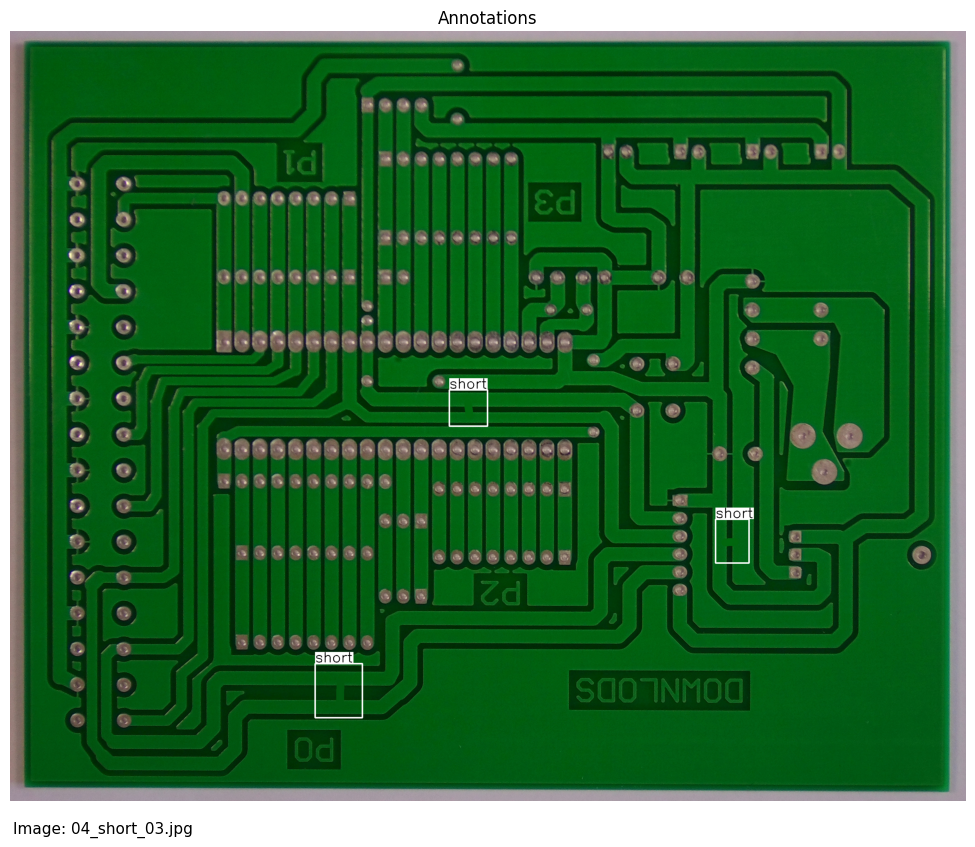

In [13]:
# Visualizing image
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

In [48]:
# Data Preprocessing
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    """
    Resize images from the input directory and save them to the output directory.

    Parameters:
    - input_dir (str): The directory containing the original images.
    - output_dir (str): The directory where resized images will be saved.
    - target_size (tuple): The target size for resizing images (width, height).
    """
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input directory
    for root, _, files in os.walk(input_dir):
        
        # Iterate over each file in the current directory
        for file in files:
            
            # Check if the file is an image with a .jpg extension
            if file.lower().endswith(('.jpg')):
                
                # Construct the full path of the image file
                image_path = os.path.join(root, file)
                
                # Read the image using OpenCV
                image = cv2.imread(image_path)

                # Resize the image to the target size
                resized_image = cv2.resize(image, target_size)

                # Construct the full path for saving the resized image
                output_path = os.path.join(output_dir, file)
                
                # Save the resized image to the output directory
                cv2.imwrite(output_path, resized_image)

# Define the directory for saving resized images
resized_img_dir = os.path.join(dataset_dir, 'images_resized')

# Resize images from the original images directory and save them to the resized images directory
resize_images(images_dir, resized_img_dir)


In [15]:
def resize_annotations(annot_df, target_size=(640, 640)):
    """
    Resize the bounding box annotations according to the target image size.

    Parameters:
    - annot_df (DataFrame): The DataFrame containing original annotation data.
    - target_size (tuple): The target size for resizing (width, height).

    Returns:
    - DataFrame: A DataFrame containing resized annotations with updated dimensions.
    """
    
    # Initialize an empty list to store resized annotation data
    all_data = []

    # Iterate through each row in the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Calculate the width and height ratios for resizing the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        # Resize the bounding box coordinates using the calculated ratios
        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Append the resized annotation data as a dictionary to the list
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    # Create a new DataFrame with the resized annotation data
    annot_df_resized = pd.DataFrame(all_data)

    # Return the DataFrame with resized annotations
    return annot_df_resized

# Resize the annotations using the defined target size
annot_df_resized = resize_annotations(annot_df)

# Display the first few rows of the resized annotation DataFrame
annot_df_resized.head()


filename  width  height         class  xmin  ymin  xmax  ymax
0  01_missing_hole_01.jpg    640     640  missing_hole   518   514   533   536
1  01_missing_hole_01.jpg    640     640  missing_hole   340   134   354   159
2  01_missing_hole_01.jpg    640     640  missing_hole   364   320   379   344
3  01_missing_hole_02.jpg    640     640  missing_hole   545    93   558   120
4  01_missing_hole_02.jpg    640     640  missing_hole   499   324   507   347

In [16]:
# Split dataset
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [17]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>

def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    """
    Convert bounding box annotations into YOLO format labels.

    Parameters:
    - annotation_df (DataFrame): The DataFrame containing annotation data
                                  with columns ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'].
    - classes (list): A list of class names (strings) representing object categories.
    - target_size (tuple): The target size for resizing the image (default is (640, 640)).

    Returns:
    - list: A list of tuples where each tuple contains YOLO formatted labels
            in the form (filename, class_index, x_center, y_center, width, height).
    """
    yolo_labels = []  # List to store YOLO labels

    # Iterate through each row in the annotation DataFrame
    for _, annot in annotation_df.iterrows():
        filename = annot['filename']  # Image file name
        width, height = annot['width'], annot['height']  # Image width and height
        class_name = annot['class']  # Object class
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']  # Bounding box coordinates

        # Convert bounding box coordinates to YOLO format (normalized values)
        x_center = (xmin + xmax) / (2 * width)  # Normalize X center
        y_center = (ymin + ymax) / (2 * height)  # Normalize Y center
        bbox_width = (xmax - xmin) / width  # Normalize width
        bbox_height = (ymax - ymin) / height  # Normalize height

        # Get class index based on the class name
        class_index = classes.index(class_name)

        # Append the YOLO formatted label (filename, class_index, x_center, y_center, width, height) to the list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels  # Return the list of YOLO labels


# Example class names
classes = ['missing_hole', 'mouse_bite', 'open_circuit', 
           'short', 'spur', 'spurious_copper']

# Convert annotations to YOLO format
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)


In [18]:
import os
import random
import shutil

def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    """
    Split images and labels into train, validation, and test sets, and organize them into separate directories.

    Parameters:
    - images_dir (str): Directory containing the images.
    - labels (list): List of YOLO formatted labels, where each label is a tuple (filename, class_index, x_center, y_center, width, height).
    - output_dir (str): Directory where the split images and labels will be saved.
    - train_split (float): Proportion of the dataset to be used for training (default is 0.95).
    - val_split (float): Proportion of the dataset to be used for validation (default is 0.05).

    Returns:
    - None
    """
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset into training, validation, and testing
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, and test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            # Save the labels
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy the image to the corresponding directory
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))


split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

In [19]:
# Cross Validation
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [20]:
# Class Index
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [21]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [22]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13668\2627102905.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`


0    1    2    3    4    5
01_missing_hole_01  21.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_02  21.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_03  21.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_04  15.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_05  28.0  0.0  0.0  0.0  0.0  0.0

In [ ]:
ksplit = 2
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [24]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

C:\Users\LEGION\AppData\Local\Temp\ipykernel_13668\3825890032.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
C:\Users\LEGION\AppData\Local\Temp\ipykernel_13668\38258900

In [25]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

0         1         2         3         4         5
split_1  1.318658  1.083921  1.353417  0.613949  0.904317  1.129239
split_2  0.758347  0.922577  0.738871    1.6288  1.105806  0.885552

In [26]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [27]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [28]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

In [27]:
# Model Training
model = YOLO('yolov8s.pt')
results = {}

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 5
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data=dataset_yaml,
                epochs=epochs,
                batch=batch,
                lr0=0.001,
                lrf=0.0001,
                imgsz=imgsz,
                save_period=save_period,
                verbose=verbose,
                project=project,
                mixup=mixup,
                device="cuda"
            )
    results[k] = model.metrics  # save output metrics for further analysis

Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\split_1_dataset.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=cuda, workers=8, project=pcb, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, clas

train: Scanning C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\train\labels... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:00<00:00, 719.06it/s]

train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\train\images\01_missing_hole_05.jpg: 20 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\train\images\01_missing_hole_06.jpg: 15 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\train\images\01_missing_hole_07.jpg: 15 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\train\images\01_missing_hole_12.jpg: 15 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DN

train: New cache created: C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\train\labels.cache


val: Scanning C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\val\labels... 347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 347/347 [00:01<00:00, 283.11it/s]

val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\val\images\01_missing_hole_01.jpg: 15 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\val\images\01_missing_hole_02.jpg: 15 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\val\images\01_missing_hole_03.jpg: 15 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\val\images\01_missing_hole_04.jpg: 9 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV 

val: New cache created: C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_1\val\labels.cache
Plotting labels to pcb\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb\train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.03G       4.23      27.41      2.256         38        640: 100%|██████████| 22/22 [00:11<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:16<00:00,  1.47s/it]

                   all        347       1496   8.15e-05    0.00685   4.21e-05   1.17e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.79G      3.497       6.22      1.541         77        640: 100%|██████████| 22/22 [00:08<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]

                   all        347       1496      0.335     0.0637    0.00102   0.000447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      2.954      4.101      1.293         42        640: 100%|██████████| 22/22 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.18s/it]

                   all        347       1496      0.457      0.196      0.186     0.0801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.76G        2.8      3.385      1.239         75        640: 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.05s/it]

                   all        347       1496      0.324      0.347      0.263      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.08G      2.679      3.037      1.185         75        640: 100%|██████████| 22/22 [00:09<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]

                   all        347       1496      0.413      0.385      0.343      0.145



5 epochs completed in 0.033 hours.
Optimizer stripped from pcb\train\weights\last.pt, 22.5MB
Optimizer stripped from pcb\train\weights\best.pt, 22.5MB

Validating pcb\train\weights\best.pt...
Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


                   all        347       1496       0.41      0.386      0.344      0.146
          missing_hole         64        280      0.781      0.903       0.91      0.425
            mouse_bite         61        258      0.305      0.213       0.15     0.0532
          open_circuit         66        278      0.279      0.147      0.132     0.0379
                 short         43        185      0.294      0.593      0.389      0.156
                  spur         55        230      0.257      0.257      0.203     0.0902
       spurious_copper         58        265      0.542        0.2      0.278      0.112
Speed: 0.4ms preprocess, 5.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to pcb\train
Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection

train: Scanning C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\train\labels... 347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 347/347 [00:00<00:00, 762.17it/s]

train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\train\images\01_missing_hole_01.jpg: 15 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\train\images\01_missing_hole_02.jpg: 15 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\train\images\01_missing_hole_03.jpg: 15 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\train\images\01_missing_hole_04.jpg: 9 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN

train: New cache created: C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\train\labels.cache


val: Scanning C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\val\labels... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:01<00:00, 273.09it/s]

val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\val\images\01_missing_hole_05.jpg: 20 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\val\images\01_missing_hole_06.jpg: 15 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\val\images\01_missing_hole_07.jpg: 15 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\val\images\01_missing_hole_12.jpg: 15 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV

val: New cache created: C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\2fold_crossval\split_2\val\labels.cache
Plotting labels to pcb\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb\train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.12G      2.544      2.798      1.167         58        640: 100%|██████████| 22/22 [00:18<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:17<00:00,  1.59s/it]

                   all        346       1457      0.468      0.422       0.39      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.87G      2.391      2.534       1.12         86        640: 100%|██████████| 22/22 [00:13<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.19s/it]

                   all        346       1457      0.553       0.49      0.489      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.84G      2.328      2.351      1.106         61        640: 100%|██████████| 22/22 [00:09<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.12s/it]

                   all        346       1457      0.694      0.508      0.557      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.11G      2.349      2.263      1.103         66        640: 100%|██████████| 22/22 [00:12<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.18s/it]

                   all        346       1457      0.703      0.551      0.609      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.98G      2.286      2.129      1.076         88        640: 100%|██████████| 22/22 [00:12<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]

                   all        346       1457      0.711      0.595       0.65      0.273



5 epochs completed in 0.051 hours.
Optimizer stripped from pcb\train2\weights\last.pt, 22.5MB
Optimizer stripped from pcb\train2\weights\best.pt, 22.5MB

Validating pcb\train2\weights\best.pt...
Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.20it/s]


                   all        346       1457      0.709      0.594      0.649      0.273
          missing_hole         51        217       0.88      0.949      0.953      0.471
            mouse_bite         54        234      0.638      0.444      0.522      0.181
          open_circuit         50        204      0.647      0.567      0.602      0.228
                 short         73        306      0.791      0.569      0.682      0.284
                  spur         60        258      0.704      0.516      0.597      0.247
       spurious_copper         58        238      0.595      0.518      0.536      0.229
Speed: 0.4ms preprocess, 5.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to pcb\train2


In [29]:
model = YOLO('yolov8s.pt')

# Additional arguments here
batch = 16
project = 'pcb'
epochs = 5
imgsz=640
save_period=1
verbose=True
# box=6.0 # Weight of the box loss component in the loss function
# cls = 2.0 # Weight of the classification loss in the total loss function
mixup = 0.3 # Blends two images and their labels, creating a composite image

all_data_yaml = f"""
path: {output_dir}
train: images/train
val: images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

data_path = os.path.join(root_dir, 'data.yaml')

with open(data_path, 'w') as f:
    f.write(all_data_yaml)

result = model.train(data=data_path,
                     epochs=epochs,
                     batch=batch,
                     lr0=0.001,
                     lrf=0.0001,
                     imgsz=imgsz,
                     save_period=save_period,
                     verbose=verbose,
                     project=project,
                     mixup=mixup,
                     device="cuda"
                )

Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=cuda, workers=8, project=pcb, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\labels\train... 693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 693/693 [00:00<00:00, 1572.86it/s]

train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\train\01_missing_hole_01.jpg: 18 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\train\01_missing_hole_02.jpg: 18 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\train\01_missing_hole_03.jpg: 18 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\train\01_missing_hole_04.jpg: 12 duplicate labels removed
train: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\train\01_missing_h

train: New cache created: C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\labels\train.cache


val: Scanning C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\labels\val... 196 images, 0 backgrounds, 0 corrupt: 100%|██████████| 196/196 [00:00<00:00, 681.37it/s]

val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_missing_hole_04.jpg: 3 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_missing_hole_13.jpg: 3 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_mouse_bite_02.jpg: 3 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_mouse_bite_09.jpg: 3 duplicate labels removed
val: WARNING  C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_mouse_bite_12.jpg: 3 duplicate labels

Plotting labels to pcb\train4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to pcb\train4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.04G      3.811      15.89       1.86         26        640: 100%|██████████| 44/44 [00:19<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]

                   all        196        817     0.0854       0.21     0.0437     0.0175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.96G      2.826      3.665      1.256         27        640: 100%|██████████| 44/44 [00:17<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        196        817      0.391       0.41      0.322       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.83G      2.545      2.756      1.155         51        640: 100%|██████████| 44/44 [00:13<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

                   all        196        817      0.525      0.496      0.486      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.13G      2.368      2.335      1.125         39        640: 100%|██████████| 44/44 [00:19<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]

                   all        196        817      0.702      0.619      0.646       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.11G      2.309      2.135      1.083         23        640: 100%|██████████| 44/44 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        196        817      0.717      0.636      0.674      0.291



5 epochs completed in 0.036 hours.
Optimizer stripped from pcb\train4\weights\last.pt, 22.5MB
Optimizer stripped from pcb\train4\weights\best.pt, 22.5MB

Validating pcb\train4\weights\best.pt...
Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


                   all        196        817      0.717      0.637      0.677      0.291
          missing_hole         30        130      0.913      0.962       0.98       0.52
            mouse_bite         35        147      0.763      0.463      0.579      0.205
          open_circuit         36        144      0.647      0.556      0.582      0.204
                 short         35        134      0.655      0.597      0.579      0.246
                  spur         26        113      0.783      0.566      0.659      0.262
       spurious_copper         34        149      0.542      0.678      0.682      0.309
Speed: 0.6ms preprocess, 6.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to pcb\train4


In [31]:
results_dir = './pcb/train4'
dest_results_dir = os.path.join(root_dir, 'results')

shutil.copytree(results_dir, dest_results_dir)

'c:\\Users\\LEGION\\Documents\\My Documents\\KU\\Second Semester\\DNN\\Assignment-V PCV defects detection using YOLO\\results'

In [32]:
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   27.4099         3.81105        15.89390         1.86033   
1      2   53.3009         2.82630         3.66450         1.25632   
2      3   75.0803         2.54528         2.75554         1.15534   
3      4  102.2750         2.36801         2.33514         1.12490   
4      5  128.9120         2.30874         2.13481         1.08342   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.08541            0.20967           0.04368   
1               0.39073            0.40976           0.32190   
2               0.52506            0.49566           0.48589   
3               0.70190            0.61879           0.64623   
4               0.71672            0.63558           0.67399   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.01748       2.82899      20.94370       1.26932  0.000326   
1              0.13020       2.38927       3.18013       1.12777  0.000527   
2              0.19532       2.22022       1.96640       1.08508  0.000595   
3              0.27954       2.04102       1.59801       1.03501  0.000400   
4              0.29132       2.00628       1.50631       1.02748  0.000200   

     lr/pg1    lr/pg2  
0  0.000326  0.000326  
1  0.000527  0.000527  
2  0.000595  0.000595  
3  0.000400  0.000400  
4  0.000200  0.000200

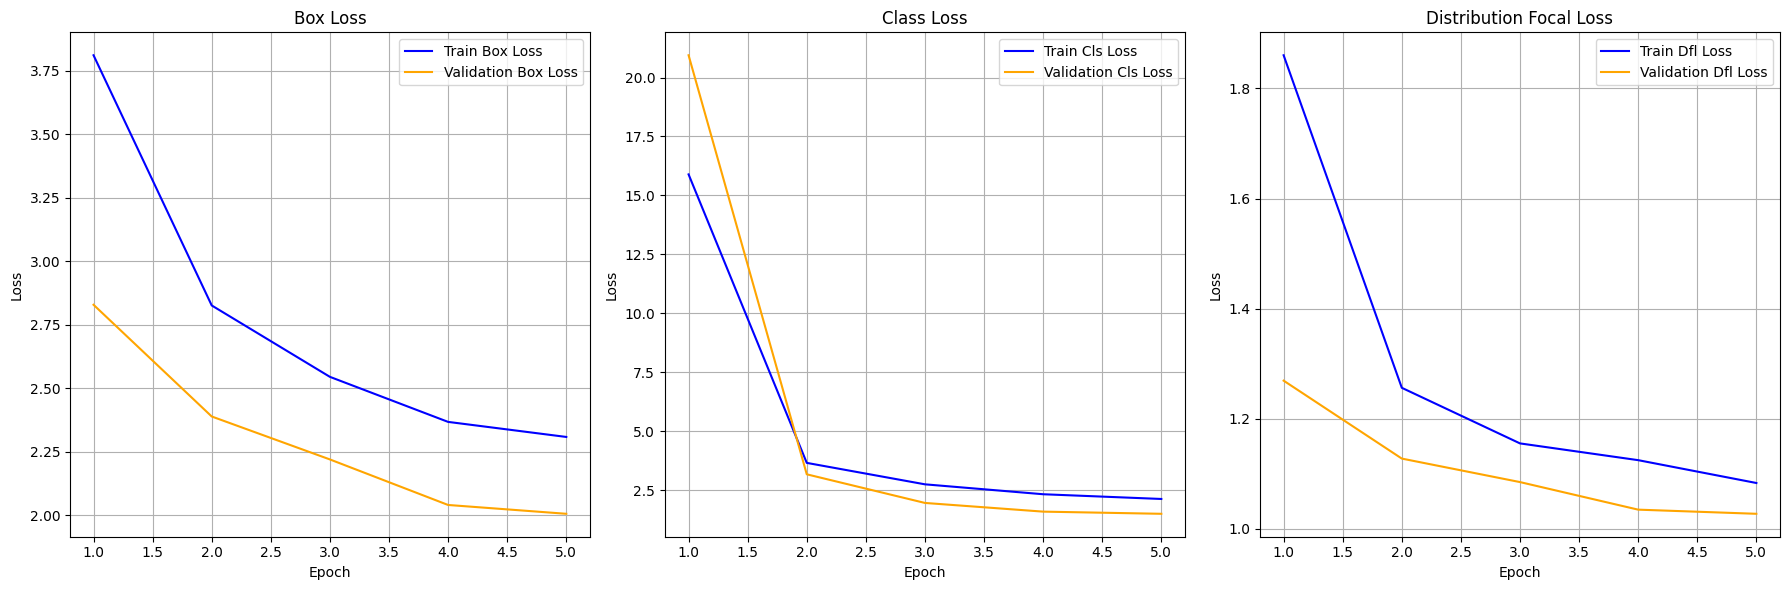

In [33]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot cls loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot dfl loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [34]:
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/196 c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_missing_hole_04.jpg: 640x640 2 missing_holes, 77.5ms
image 2/196 c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_missing_hole_08.jpg: 640x640 3 missing_holes, 11.0ms
image 3/196 c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_missing_hole_13.jpg: 640x640 3 missing_holes, 11.0ms
image 4/196 c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_missing_hole_14.jpg: 640x640 3 missing_holes, 10.5ms
image 5/196 c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\PCB_DATASET\output\images\val\01_missing_hole_16.jpg: 6

In [36]:
predict_dir = './runs/detect/predict'
dest_predict_dir = os.path.join(root_dir, 'results/predict')

shutil.copytree(predict_dir, dest_predict_dir)

'c:\\Users\\LEGION\\Documents\\My Documents\\KU\\Second Semester\\DNN\\Assignment-V PCV defects detection using YOLO\\results/predict'

In [37]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # Extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # Extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # Scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # Calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # Append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)


In [39]:
dest_predict_dir

'c:\\Users\\LEGION\\Documents\\My Documents\\KU\\Second Semester\\DNN\\Assignment-V PCV defects detection using YOLO\\results/predict'

In [40]:
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels

file_path = os.path.join(dest_predict_dir, 'labels/12_spurious_copper_08.txt')
yolo_labels = read_yolo_labels_from_file(file_path)
yolo_labels

[[5.0, 0.898736, 0.287091, 0.0152439, 0.0423653, 0.527342],
 [5.0, 0.702266, 0.907263, 0.0325382, 0.0157433, 0.495553],
 [5.0, 0.730352, 0.579303, 0.014369, 0.0346945, 0.334309],
 [5.0, 0.332754, 0.4766, 0.0291555, 0.0126569, 0.278818],
 [5.0, 0.942329, 0.726429, 0.014962, 0.0345655, 0.252132]]

In [41]:
pred_annot_df = yolo_to_original_annot('12_spurious_copper_10.jpg', yolo_labels, annot_df, classes)
pred_annot_df.head()

filename  width  height            class  xmin  ymin  \
0  12_spurious_copper_10.jpg   2529    2530  spurious_copper  2253   672   
1  12_spurious_copper_10.jpg   2529    2530  spurious_copper  1734  2275   
2  12_spurious_copper_10.jpg   2529    2530  spurious_copper  1828  1421   
3  12_spurious_copper_10.jpg   2529    2530  spurious_copper   804  1189   
4  12_spurious_copper_10.jpg   2529    2530  spurious_copper  2364  1794   

   xmax  ymax  confidence  
0  2292   779    0.527342  
1  1817  2315    0.495553  
2  1865  1509    0.334309  
3   878  1221    0.278818  
4  2402  1881    0.252132

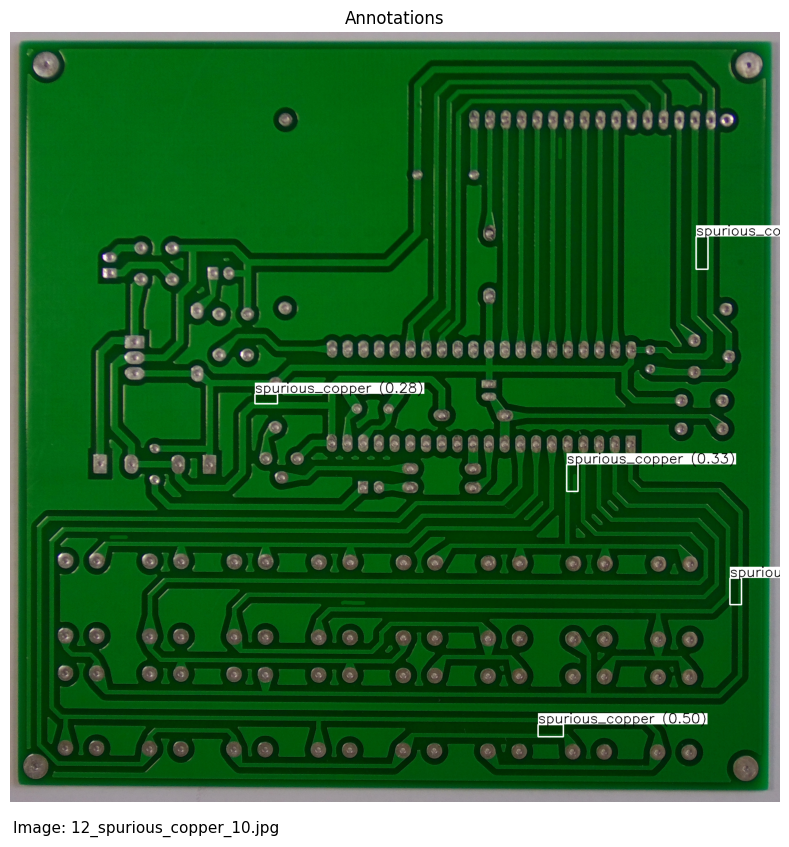

In [42]:
visualize_annotations('12_spurious_copper_10.jpg', images_dir, pred_annot_df, is_subfolder=True);

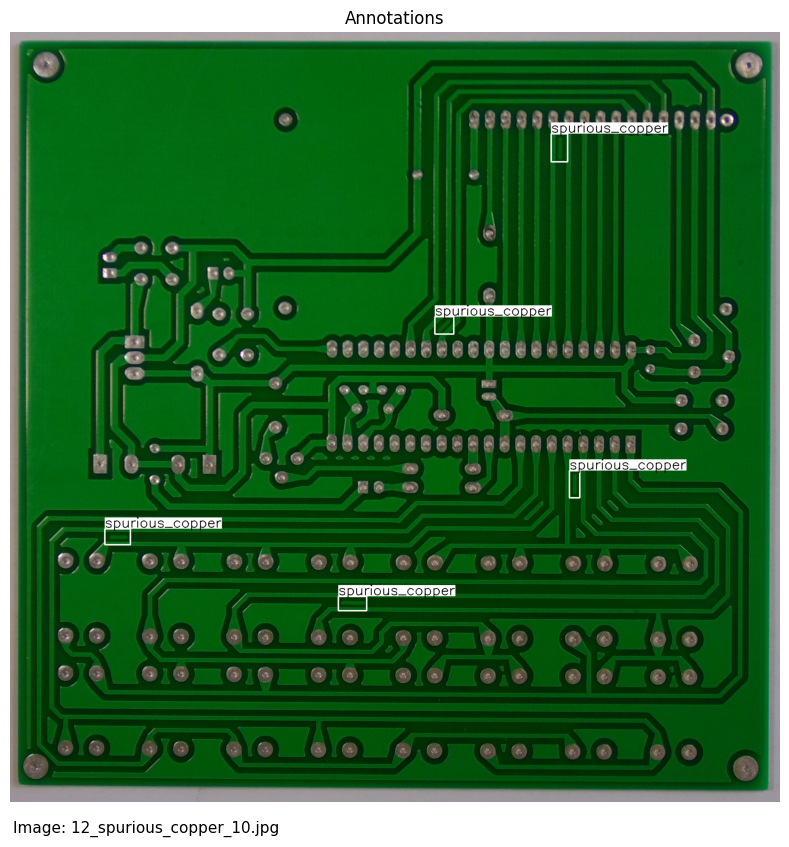

In [43]:
visualize_annotations('12_spurious_copper_10.jpg', images_dir, annot_df, is_subfolder=True);

In [ ]:
model.export("YOLOv8sm.pt")

Ultralytics 8.3.28  Python-3.12.4 torch-2.5.1+cu118 CPU (AMD Ryzen 7 5800H with Radeon Graphics)

PyTorch: starting from 'c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\results\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (21.5 MB)

TorchScript: starting export with torch 2.5.1+cu118...
TorchScript: export success  2.2s, saved as 'c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\results\weights\best.torchscript' (42.9 MB)

Export complete (2.7s)
Results saved to C:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\results\weights
Predict:         yolo predict task=detect model=c:\Users\LEGION\Documents\My Documents\KU\Second Semester\DNN\Assignment-V PCV defects detection using YOLO\results\weights\best.torchscript imgsz=640  
Validate:        yolo val task=detect model

'c:\\Users\\LEGION\\Documents\\My Documents\\KU\\Second Semester\\DNN\\Assignment-V PCV defects detection using YOLO\\results\\weights\\best.torchscript'